# 数据集和数据加载器

PyTorch 提供了两个数据基类： torch.utils.data.DataLoader 和 torch.utils.data.Dataset。允许你使用预加载的数据集以及你自己的数据集。 Dataset 存储样本和它们相应的标签，DataLoader 在 Dataset 基础上添加了一个迭代器，迭代器可以迭代数据集，以便能够轻松地访问 Dataset 中的样本。

## 1. 加载一个数据集

加载 FashionMNIST Dataset 参数如下：
root 是存储训练/测试数据的路径,
train 指定训练或测试数据集,
download=True 如果 root 指定的目录没有数据，就自动从网上下载数据。
transform 和 target_transform 指定特征和标签的转换。

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor() # 转换为tensor形式
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:08<00:00, 2985602.42it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 119233.14it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3155303.93it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



## 2. 迭代和可视化数据集

我们可以像列表一样手动索引 Datasets：training_data[index]。 我们使用 matplotlib 来可视化我们训练数据中的一些样本。

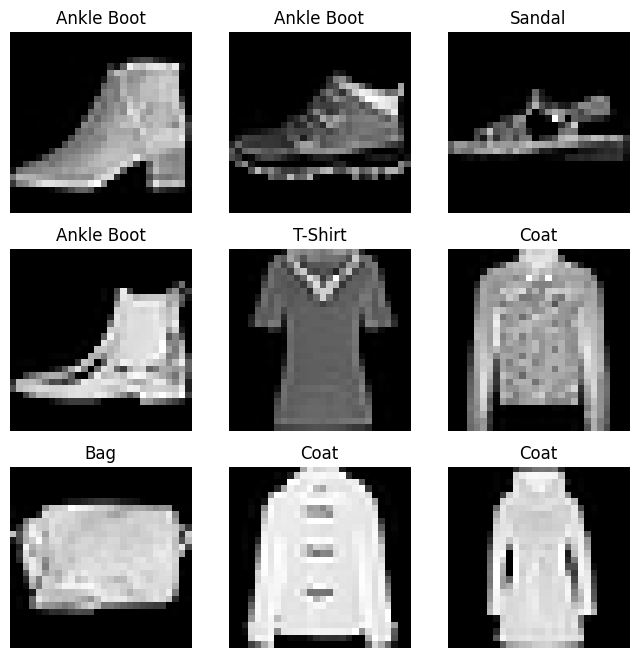

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
# figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True)
# num:图像编号或名称，数字为编号 ，字符串为名称
# figsize:指定figure的宽和高，单位为英寸；
# dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80 1英寸等于2.5cm,A4纸是 21*30cm的纸张
# facecolor:背景颜色
# edgecolor:边框颜色
# frameon:是否显示边框
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(training_data), size=(1,)).item()
# torch.randint(low, high=None, size=(), dtype=None, device=None, requires_grad=False) 是一个用来生成指定范围内随机整数的函数。
# low 是随机数的下限，high 是上限。如果只有一个参数 low 被指定，它会生成一个在 [0, low) 范围内的随机整数。
# size 参数指定生成的随机数的形状，它是一个元组，表示生成多少个随机数。这里的 size=(1,) 表示生成一个随机数。
# .item() 是 PyTorch 中一个非常有用的方法，用来将只有一个元素的张量转换为一个 Python 标量。这里 .item() 会把 torch.randint(len(training_data), size=(1,)) 返回的张量中的单个值提取出来，变成一个普通的 Python 整数。
    img, label = training_data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray")
plt.show()

## 3. 创建一个自定义的数据集

一个自定义的数据集类必须实现三个函数： __init__, __len__, 和 __getitem__。

- __init__(self, ...)：初始化数据集，通常在这个方法中加载数据。
- __len__(self)：返回数据集的大小，告诉 DataLoader 有多少数据。
- __getitem__(self, idx)：根据索引 idx 返回一个数据样本，通常是图像和标签的元组。

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)  # 读取CSV文件，包含图像路径和标签
        self.img_dir = img_dir  # 图像存储的目录
        self.transform = transform  # 用于图像转换的函数
        self.target_transform = target_transform  # 用于标签转换的函数

    def __len__(self):
        return len(self.img_labels)

    # 函数 __getitem__ 从数据集中给定的索引 idx 处加载并返回一个样本。
    # 根据索引可以确定图像在硬盘上的位置，用 read_image 将其转换为tensor
    # 从 self.img_labels 的csv数据中获取相应的标签
    # 再对它们调用 transform 函数(如果适用)，并返回tensor图像和相应的标签的元组。
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # 获取图像的路径
        image = read_image(img_path)  # 使用read_image读取图像并转换为Tensor
        label = self.img_labels.iloc[idx, 1]  # 获取对应的标签
        if self.transform:
            image = self.transform(image)  # 如果有transform，就应用到图像上
        if self.target_transform:
            label = self.target_transform(label)  # 如果有target_transform，就应用到标签上
        return image, label  # 返回图像和标签的元组


## 4. 遍历DataLoader

我们已经将该数据集加载到 DataLoader 中，并可以根据需要迭代该数据集。每次迭代都会返回一批 train_features 和 train_labels (分别包含 batch_size=64 个特征和标签)。因为我们指定了 shuffle=True，在我们遍历所有批次后，数据会被打乱

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


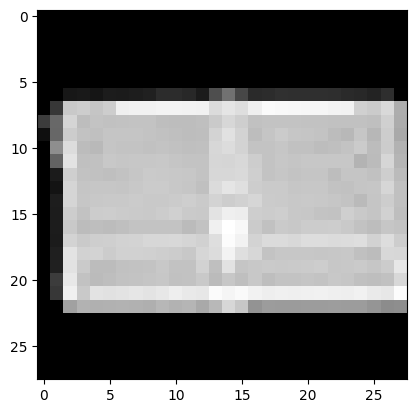

Label: 8


In [14]:
# 显示图像
# next(iter(train_dataloader)) 从 train_dataloader 中获取一个批次的数据
# train_features 是图像张量，train_labels 是对应的标签。
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# train_features[0] 取批次中的第一张图像。
# squeeze() 用于去除多余的维度，例如，如果图像是灰度图像（即通道数为 1），squeeze() 会去掉维度 C=1，使得图像变成 (H, W) 形状。如果图像是 RGB 图像，则可能不需要 squeeze()。
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 5. 数据转换

数据并不总是以训练机器学习算法所需的最终处理形式出现。我们使用变换来对数据进行一些处理，使其适合训练。

所有的 TorchVision 数据集都有两个参数: transform 用于修改特征和 target_transform 用于修改标签，它们接受包含转换逻辑的 callables。torchvision.transforms 模块提供了几个常用的转换算法，开箱即用。

In [15]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    # 标签转换操作：将标签转换为 one-hot 编码形式
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # 将每个标签 y 转换为 one-hot 编码。y 是数字标签（0 到 9），而 scatter_ 会将其转换为一个长度为 10 的张量，在对应的索引位置设置为 1，其他位置为 0。
    # .scatter_(0, torch.tensor(y), value=1):
    # scatter_ 是一个原地（in-place）操作，它会在张量的指定位置修改数据。
    # scatter_(dim, index, value)：该操作的作用是将 value 填充到 index 所指定的位置，dim 指定了要修改的维度。
    # dim=0：表示我们在第 0 维上进行操作（即在一维张量上）。
    # index=torch.tensor(y)：y 是标签，它是一个标量（表示当前类别的标签）。torch.tensor(y) 将其转换为张量。假设 y 的值是 3，那么 index 就是 tensor(3)。
    # value=1：表示在索引位置 index 处填入 1。
)